# Competition in Insurance - Veiga and Weyl (2016)

Application shows how market power can improve welfare by counteracting cream-skimming incentives.

**Consumers**:
- $\theta = (\mu, \nu, b) \in \mathbf{R}_+^2 \times [0, 1]$: consumer type
- $\mu$: expenditure shifter
- $\nu$: preference parameter that captures value of insurance
- $b\sim \mathcal{U}[0,1]$: Hotelling location parameter
- $\phi = \mu^{\frac{1}{e}}\frac{1}{e-1}e m ^\frac{e-1}{e}$: value of medical expenditure $m$
- $m^*=\frac{\mu}{(1-x)^e}$: optimal medical expenditure when insurer absorbs pays share $x$ of medical spending
    - $m^*\equiv\argmax_m \mu^{\frac{1}{e}}\frac{1}{e-1}e m ^\frac{e-1}{e} - (1-x)m$
- $w_0$: initial wealth
- $w$: final wealth
- $u(w)=-e^{-aw}$: utility index over final wealth (CARA preferences)



**Insurers**:
- $i,j \in {0,1}$: index for each of two insurers
- $x_i \in [0, 1]$: share of loss $l$ paid by insurer $i$
- $p_i \geq 0$ : premium of contract offered by insurer $i$
- $c \equiv \mu k(x)\equiv \mu x(1-x)^{-e} $ : expected cost of providing insurance
- $l \sim \mathcal{N}(\mu, \sigma^2)$: Gaussian wealth shocks
- $t$: travel cost (captures market power)
- $d_0 = b \times 1[b>.5]$: distance to insurer 0
- $d_1 = (1-b) \times 1[b\leq.5]$: distance to insurer 1
- $u = \mu h(x) + \psi(x)v - td$: WTP for insurance
    - With CARA preferences we get $ u = \mu h(x) + \psi(x)v - td$
    - where $h(x) = \frac{1-(1-x)^{1-e}}{1-e}$ and $\psi(x) = \frac{1}{2}(1-(1-x)^2)$






**Import libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import nquad
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import root
from scipy.special import roots_hermite
from tabulate import tabulate
import quantecon as qe
import pickle
import matplotlib.ticker as ticker


Calculate the parameters of the distribution of demographics:

$(\mu , \nu)$ has a joint log normal distribution :

$$ \begin{pmatrix} \log(\mu) \\ \log(\nu) \end{pmatrix} \sim \mathcal{N}\Bigg(\begin{pmatrix}m_\mu \\ m_\nu\end{pmatrix} , \begin{pmatrix} V_\mu & C \\ C & V_\nu \end{pmatrix}\Bigg)$$

where 
- $\mathbb{E}[\mu] = \exp({m_\mu+\frac{1}{2}V_\mu})$
- $\mathbb{E}[\nu] = \exp({m_\nu+\frac{1}{2}V_\nu})$ 
- $\mathbb{V}[\mu]=\mathbb{E}[\mu]^2(\exp(V_\mu)-1)$
- $\mathbb{V}[\nu]=\mathbb{E}[\nu]^2(\exp(V_\nu)-1)$
- $\mathbb{Cov}[\mu, \nu]=\mathbb{E}[\mu]\mathbb{E}[\nu](\exp(C)-1)$

Note that: 
- $\mathbb{V}[\mu]$ and $V_\mu \equiv \mathbb{V}[\log\mu]$ are different objects
- To obtain $\mathbb{Cov}[\mu, \nu]$, note that $z\equiv \mu\nu$ has a log-normal distribution, since $\log(\mu\nu)=\log\mu + \log\nu$ and $\log\mu$ and $\log\nu$ have a **joint** normal distribution.

- The formula for the expected value of a log-normall distributed variable implies that
$$\mathbb{E}[\mu\nu]= \exp\Big(m_\mu + m_\nu + \frac{1}{2}(V_\mu + V_\nu + 2C)\Big) = \mathbb{E}[\mu]\mathbb{E}[\nu]\exp (C)$$

- where we use 
    $$\mathbb{E}[\log(\mu\nu)]=\mathbb{E}[\log\mu]+\mathbb{E}[\log\nu]=m_\mu + m_\nu$$
    and 
    $$\mathbb{V}[\log(\mu\nu)]=\mathbb{V}[\log\mu + \log\nu] = V_\mu + V_\nu + 2C$$

To obtain $m_\mu=8.4$, $m_\nu=11$, $V_\mu=.76$, $V_\nu=1.2$ and $C=.63$, VW use the following values from the HHW data to solve the system of equations analytically:
- $\mathbb{E}[\mu]=6.6\times10^3$
- $\mathbb{E}[\nu]=68\times 10^3$
- $\mathbb{V}[\mu]=50\times 10^6$
- $\mathbb{V}[\nu] = \mathbb{E}[a]^2\mathbb{V}[\sigma^2]=9.8\times10^9$
- $\mathbb{Cov}[\mu, \nu]=630\times10^6$


**Confirm analytical solution with numerical solution:**

In [4]:
# Set data values and define function for system of equations:
E_μ = 6.6E3
E_ν = 68E3
Var_μ = 50E6
Var_ν = 9.8E9
Cov = 630E6

# Set solution in text
m_μ = 8.4
m_ν = 11
V_μ = .76
V_ν = 1.2
C = .63

def f(val):
    # Unpack parameters
    m_μ , m_ν, V_μ, V_ν, C = val
    # Define system of equations
    f1 = np.log(E_μ)-.5*V_μ - m_μ
    f2 = np.log(E_ν)-.5*V_ν - m_ν
    f3 = np.log((Var_μ / E_μ**2) + 1) - V_μ
    f4 = np.log((Var_ν / E_ν**2) + 1) - V_ν
    f5 = np.log((Cov / (E_μ*E_ν)) + 1) - C
    return [f1, f2, f3, f4, f5]

# Check solution in text
print(f''' Analytic solution in text:
          m_μ = {m_μ}
          m_ν = {m_ν}
          V_μ = {V_μ}
          V_ν = {V_ν}
          C = {C}
    ''')
print(f'''Solution in text is similar: {f([8.4, 11, .76, 1.2, .63])}\n''')

# Solve system of equations
val0 = [0.5, 0.5, 0.5, 0.5, 0.6]
sol = fsolve(f, val0)

print(f'''Numerical solution:
          m_μ = {sol[0]:.2f}
          m_ν = {sol[1]:.2f}
          V_μ = {sol[2]:.2f}
          V_ν = {sol[3]:.2f}
          C = {sol[4]:.2f}
    ''')

# Check numerical solution
print(f'''Check numerical solution: {f(sol)}''')

 Analytic solution in text:
          m_μ = 8.4
          m_ν = 11
          V_μ = 0.76
          V_ν = 1.2
          C = 0.63
    
Solution in text is similar: [0.014824928014515848, -0.47273701584175676, 0.00446364365121843, -0.06236664546906012, 0.2470272370570884]

Numerical solution:
          m_μ = 8.41
          m_ν = 10.56
          V_μ = 0.76
          V_ν = 1.14
          C = 0.88
    
Check numerical solution: [0.0, 0.0, 0.0, 0.0, 0.0]


**Formula for the joint density of $\mu$ and $\nu$:**

$$f(\mu, \nu) = f_{\mu\mid\nu}(\mu\mid\nu)f_\nu(\nu)$$


where

$$\log \nu \sim \mathcal{N}(m_\nu, V_\nu) $$

and

$$ \log \mu \mid \nu \sim \mathcal{N}\Big(m_\mu + \frac{C}{V_\nu}(\log\nu - m_\nu) , (1-\rho^2)V_\mu\Big)$$


This comes from the fact that the joint distribution of $\log\mu$ and $\log\nu$ is normal, and the conditional distribution of $\log\mu$ given $\log\nu$ is normal as well.

Let $\rho=\frac{C}{\sqrt{V_\mu V_\nu}}$

The conditional expectation and variance of $\log\mu$ given $\log\nu$ are:
$$ E[\log\mu \mid \log\nu] = m_\mu + \rho\sqrt{V_\mu}\frac{(\log\nu - m_\nu)}{\sqrt{V_\nu}} = m_\mu + \frac{C}{V_v}(\log\nu - m_\nu) $$

and

$$ V[\log\mu \mid \log\nu] =  V_\mu - \frac{C^2}{V_\nu} $$

**Formula given in the paper for the conditional density:**

$$ \log \mu \mid \nu \sim \mathcal{N}\Big(8.4 + .53(\log\nu - 11), .43\Big)$$


Check that the parameters in the paper are conssitent with the parameters in the analytical solution:


In [5]:
print(f'''Conditional variance is: {V_μ-C**2/V_ν}''')
print(f'''Coefficient on second term is: {C/V_ν}''')

Conditional variance is: 0.42924999999999996
Coefficient on second term is: 0.525


In [6]:
class HHW_mkt():
    def __init__(self,
                 e = .2, # Moral Hazard
                 t = 8_000, # Transport cost
                 x_hat = .86, # Typical coverage level for MH adjustment
                 #m_ν = 11,
                 #m_μ = 8.4,
                 #V_ν = 1.2,
                 #V_μ = .76,
                 #C = 0.63,
                 m_ν = 10.56,
                 m_μ = 8.41,
                 V_ν = 1.14,
                 V_μ = .76,
                 C = 0.88,
                 h = lambda x, m: (1-(1-x)**(1-m))/(1-m),  # Captures moral hazard, baseline is no moral hazard
                 ψ = lambda x: .5*(1-(1-x)**2), # Captures willingness to pay for reduction in risk
                 k = lambda x, m: x*(1-x)**(-m), # Captures the cost given optimal medical expenditures: c = k(x, m)*μ
                 gh_N = 1_000, # Number of nodes for Gauss-Hermite Quadratures
                 ):
        self.e = e
        self.x_hat = x_hat
        self.m_ν = m_ν
        self.m_μ = m_μ
        self.V_ν = V_ν
        self.σ_ν = np.sqrt(V_ν)
        self.V_μ = V_μ
        self.σ_μ = np.sqrt(V_μ)
        self.C = C
        self.h = lambda x: h(x, e)
        self.ψ = ψ
        self.k = lambda x: k(x, e) 
        self.α = (1-x_hat)**e
        self.ρ = C / np.sqrt(V_μ*V_ν)
        self.m_μ_adj = m_μ + np.log(self.α)
        self.t = t

        # Atrributes for Gauss-Hermite Quadratures (Bivariate Normal)
        self.x_n , self.w_n = roots_hermite(gh_N)
        self.X1, self.X2 = np.meshgrid(self.x_n, self.x_n)
        self.W1, self.W2 = np.meshgrid(self.w_n, self.w_n)
        self.X = np.vstack((self.X1.flatten(), self.X2.flatten())).T
        self.W = np.multiply(self.W1.flatten(), self.W2.flatten())
        self.mv_c = 1 / np.pi # Multi-variate constant
        self.μ_vec = np.array([self.m_μ_adj, m_ν])
        self.Σ = np.array([[V_μ, C], [C, V_ν]])
        self.L = np.linalg.cholesky(self.Σ)
        self.Y = np.sqrt(2)*(self.L@self.X.T).T + self.μ_vec[None, :] # Values of X after change of variables
        self.Y_μ, self.Y_ν = np.exp(self.Y[:, 0]), np.exp(self.Y[:, 1])

        # Extra atrributes for Gauss-Hermite Quadratures (Normal)
        self.uv_c = 1 / np.sqrt(np.pi) # Uni-variate constant
        self.y_ν = np.exp(np.sqrt(2)*self.σ_ν*self.x_n + self.m_ν)

        
    def c(self, μ, x, **kwargs):
        '''Cost to insurer of individual with type μ when offering coverage x'''
        return μ*self.k(x)
    
    def mc(self, μ, x, **kwargs):
        '''Marginal cost to insurer of individual with type μ when offering coverage x'''
        return μ*((1-x)**(-self.e)+x*self.e*(1-x)**(-self.e-1))
    
    def wtp(self, μ, ν, x, **kwargs):
        '''Willingness to pay for individual with type μ and ν for coverage x'''
        return self.h(x)*μ + self.ψ(x)*ν
    
    def mwtp(self, μ, ν, x, **kwargs):
        '''Marginal willingness to pay for individual with type μ and ν for coverage x'''
        return μ*(1-x)**(-self.e) + (1-x)*ν
    
    def μ_tilde(self, ν, p, x):
        '''Threshold of μ that defines buyers group'''
        return (p - self.ψ(x)*ν)/self.h(x)
    
    def ν_bar(self, p, x):
        '''Threshold of ν at which all μs buy'''
        return p/self.ψ(x)
    
    def f_ν(self, ν):
        '''Density of ν'''
        return lognorm.pdf(ν, s=self.σ_ν, scale=np.exp(self.m_ν))
    
    def f_μ_ν(self, μ, ν):
        '''Density of μ conditional on ν'''
        sigma_μ = np.sqrt((1-self.ρ**2)*self.V_μ)
        #sigma_μ = np.sqrt(.43)
        sca_μ = np.exp(self.m_μ + np.log(self.α) + self.C*(np.log(ν) - self.m_ν)/self.V_ν)
        #sca_μ = np.exp(self.m_μ + np.log(self.α) + .53*(np.log(ν) - self.m_ν))
        return lognorm.pdf(μ, s=sigma_μ, scale=sca_μ)
    
    def f(self, μ, ν):
        '''Joint density of μ and ν'''
        return self.f_ν(ν)*self.f_μ_ν(μ, ν)
    
    def tc(self, b,  i=0):
        '''Transport cost to insurer i'''
        if b>=.5:
            if i == 0:
                return b*self.t
            if i == 1:
                return 0
        if b<.5:
            if i == 0:
                return 0
            if i == 1:
                return (1-b)*self.t
        
    def D(self, p0, x0, p1, x1, μ, ν, b, i=0):
        '''Demand indicators'''
        wtp, tc = self.wtp, self.tc
        u0 = wtp(μ, ν, x0) - p0 - tc(b, i=0)
        u1 = wtp(μ, ν, x1) - p1 - tc(b, i=1)
        if i==0:
            return u0 > np.max(u1, 0)
        if i==1:
            return u1 > np.max(u0, 0)
    
    # Functions for expected values over the switching margin (same as buyers group)
    def E_S(self, p, x, N=100_000, F= lambda **kwargs: 1, int='gh'):
        '''Generic function for the expected value of F over the buyers group (without dividing by Q)
              N: Number of draws for Monte Carlo, or Limits of Integration for Double Quad
              F: Function to integrate
              int: Integration method (mc, dbquad, gh)
        '''
        # Unpack parameters
        m_ν, V_μ, V_ν, C, m_μ_adj = self.m_ν, self.V_μ, self.V_ν, self.C, self.m_μ_adj

        # Monte Carlo approach
        if int == 'mc':
            mus = np.array([m_μ_adj, m_ν])
            varcov = np.array([[V_μ, C], [C, V_ν]])
            rng = np.random.default_rng(seed=42)
            draws_μ , draws_ν = np.exp(rng.multivariate_normal(mus, varcov, N)).T
            μ_tildes = self.μ_tilde(draws_ν, p, x)
            func = F(μ = draws_μ, ν = draws_ν, p=p, x=x)
            res = np.mean(func*(draws_μ > μ_tildes))

        # Double quad approach (slow, but works)
        if int == 'dbquad': 
            #TODO: introduce limits of integration 
            integrand = lambda μ, ν: F(μ=μ, ν=μ, p=p, x=x)*self.f(μ, ν)*(μ > self.μ_tilde(ν, p, x))
            res = nquad(integrand, [[0, N], [0, N]], opts=[{'limit':50}, {'limit':50}])
        
        # Gauss-Hermite Quadrature
        if int == 'gh':
            func = F(μ = self.Y_μ, ν = self.Y_ν, p=p, x=x)
            μ_tildes = self.μ_tilde(self.Y_ν, p, x)
            res = np.sum(func*(self.Y_μ > μ_tildes)*self.W*self.mv_c)

        # Output
        return res
        
    def Q(self, p, x, N=100_000, int='gh'):
        '''Share of all buyers'''
        return self.E_S(p, x, N, int = int)
    
    def E_mc_S(self, p, x, N=100_000, int='gh'):
        '''Expected marginal cost of Switcher group'''
        Q = self.Q(p, x, N, int)
        return (1/Q)*self.E_S(p, x, N, F=self.mc, int=int)
    
    def E_c_S(self, p, x, N=100_000, int='gh'):
        '''Expected cost of Switcher group'''
        Q = self.Q(p, x, N, int)
        return (1/Q)*self.E_S(p, x, N, F=self.c, int = int)
    
    def E_mwtp_S(self, p, x, N=100_000, int='gh'):
        '''Expected marginal willingness to pay of Switcher group'''
        Q = self.Q(p, x, N, int)
        return (1/Q)*self.E_S(p, x, F=self.mwtp, int = int)
    
    def E_mupc_S(self, p, x, N=100_000, int='gh'):
        '''Last term in FOC for x'''
        Q = self.Q(p, x, N, int)
        func = lambda μ, ν, p, x, **kwargs: self.mwtp(μ, ν, x)*(p-self.c(μ, x))
        return (1/Q)*self.E_S(p, x, F=func, int = int)

    def S(self, p, x, N=100_000, int='gh'):
        '''Total density of switchers'''
        #return self.Q(p, x, N)[0] / (2*self.t)
        return self.Q(p, x, N, int) / (self.t)
    
    def Π_LSE(self, p, x, N=100_000, int='gh'):
        '''Total profits at an LSE
            - Note that they are not a function of transport cost because in equilibrium no one is paying transport cost
        '''
        Q = self.Q(p, x, N, int)
        return (Q/2)*(p-self.E_c_S(p, x, N, int = int))
    
    def b_tilde(self, p, x, N=100_000, int='gh'):
        '''Threshold of b that defines buyers group'''
        return self.ψ(x)*self.ν_bar(p, x)
    
    def Π(self, p0, x0, p1, x1, N=100_000, int='gh'):
        '''Total profits'''
        mus = np.array([m_μ_adj, m_ν])
        varcov = np.array([[V_μ, C], [C, V_ν]])
        rng = np.random.default_rng(seed=42)
        draws_μ , draws_ν = np.exp(rng.multivariate_normal(mus, varcov, N)).T
        draws_b = np.linspace(0, 1)


        μ_tildes = self.μ_tilde(draws_ν, p, x)
        func = F(μ = draws_μ, ν = draws_ν, p=p, x=x)
        res = np.mean(func*(draws_μ > μ_tildes))
        #TODO: finish this function

    def WELF(self, p, x, N=100_000, int='gh'):
        '''Total welfare'''
        func = lambda μ, ν, p, x, **kwargs: self.wtp(μ, ν, x)-self.c(μ, x)
        return self.E_S(p, x, F=func, int=int)

    # Functions for expected values over exiting margin
    def E_E(self, p, x, N=1_000_000, F= lambda **kwargs: 1, int='gh'):
        '''Generic function for the expected value of F over the exiting group (without dividing by E)
                N: Number of draws for Monte Carlo, or Limits of Integration for Double Quad
                F: Function to integrate
                int: Integration method (mc, dbquad, gh)
        '''
        # Unpack parameters
        m_ν, V_μ, V_ν, C, m_μ_adj, ρ, σ_ν, σ_μ = self.m_ν, self.V_μ, self.V_ν, self.C, self.m_μ_adj, self.ρ, self.σ_ν, self.σ_μ
        # Unpack functions
        h, ψ , f_μ_ν, f_ν , f, μ_tilde, ν_bar = self.h, self.ψ, self.f_μ_ν, self.f_ν, self.f, self.μ_tilde, self.ν_bar

        # Monte Carlo approach
        if int == 'mc':
            rng = np.random.default_rng(seed=42)
            draws_ν = rng.lognormal(mean=m_ν, sigma=σ_ν, size=N)
            μ_tildes = μ_tilde(draws_ν, p, x)
            ν_bars = ν_bar(p, x)
            func = F(ν = draws_ν, μ = μ_tildes, p=p, x=x)
            res = np.mean(.5*(1/h(x))*func*(draws_ν < ν_bars)*f_μ_ν(μ = μ_tildes, ν = draws_ν))

        # Double quad approach (slow, but works) 
        if int == 'dbquad':
            #TODO: introduce limits of integration 
            integrand = lambda ν: .5*(1/h(x))*(ν < ν_bar(p, x))*F(μ=μ_tilde(ν, p, x), ν=ν, p=p, x=x)*f(μ_tilde(ν, p, x), ν)
            res = nquad(integrand, [[0, N]], opts=[{'limit':50}])
            res = res[0]
        
        # Gauss-Hermite Quadrature
        if int == 'gh':
            μ_tildes = self.μ_tilde(self.y_ν, p, x)
            func = F(ν = self.y_ν, μ = μ_tildes, p=p, x=x)
            ν_bars = self.ν_bar(p, x)
            res = np.sum(self.uv_c*self.w_n*(self.y_ν < ν_bars)*func*.5*(1/h(x))*f_μ_ν(μ = μ_tildes, ν = self.y_ν))
        
        # Output results
        return res
    
    def E(self, p, x, N=100_000, int='gh'):
        '''Share of all exiting'''
        return self.E_E(p, x, N, int=int)
    
    def E_mc_E(self, p, x, N=100_000, int='gh'):
        '''Expected marginal cost of exiting group'''
        E = self.E(p, x, N, int=int)
        return (1/E)*self.E_E(p, x, N, F=self.mc, int=int)
    
    def E_c_E(self, p, x, N=100_000, int='gh'):
        '''Expected cost of exiting group'''
        E = self.E(p, x, N, int=int)
        return (1/E)*self.E_E(p, x, N, F=self.c, int=int)
    
    def E_mwtp_E(self, p, x, N=100_000, int='gh'):
        '''Expected marginal willingness to pay of exiting group'''
        E = self.E(p, x, N, int=int)
        return (1/E)*self.E_E(p, x, N, F=self.mwtp, int=int)
    
    def E_mupc_E(self, p, x, N=100_000, int='gh'):
        '''Last term in FOC for x'''
        E = self.E(p, x, N, int=int)
        func = lambda μ, ν, p, x, **kwargs: self.mwtp(μ, ν, x)*(p-self.c(μ, x))
        return (1/E)*self.E_E(p, x, N, F=func, int=int)

    # Total density of marginals
    def M(self, p, x, N=100_000, int='gh'):
        '''Total density of marginals'''
        return self.S(p, x, N, int=int) + self.E(p, x, N, int=int)
    
    # FIRST ORDER CONDITIONS
    def foc_p(self, p, x, N=100_000, int='gh'):
        '''First order condition for p'''
        # Unpack margins
        E, S, M, Q = self.E(p, x, N, int=int), self.S(p, x, N, int=int), self.M(p, x, N, int=int), self.Q(p, x, N, int=int)
        #foc = p - (S/M)*self.E_c_S(p, x, N, int=int) - (E/M)*self.E_c_E(p, x, N, int=int) - .5*Q/M
        foc = - p + (S/M)*self.E_c_S(p, x, N, int=int) + (E/M)*self.E_c_E(p, x, N, int=int) + .5*Q/M
        return foc
    
    def foc_x(self, p, x, N=100_000, int='gh'):
        '''First order condition for x'''
        # Unpack margins
        E, S, Q = self.E(p, x, N, int=int), self.S(p, x, N, int=int),  self.Q(p, x, N, int=int)
        # Unpack functions for Expected Values for Exiteers
        E_mc_S, E_mupc_E, E_mupc_S = self.E_mc_S, self.E_mupc_E, self.E_mupc_S
        foc = .5*Q*E_mc_S(p, x, N, int=int) - E*E_mupc_E(p, x, N, int=int) - S*E_mupc_S(p, x, N, int=int)
        return foc

    # Solve for equilibrium
    def solve_eq(self, p_guess = 30_000, x_guess = .55, bounds_p = [0, 100_000], N=100_000, int='mc', method='hybr'):
        '''Solve for equilibrium prices and shares using Scipy's fsolve.
           Solve the problem for prices a system of two equations in two unknowns.
        '''
        # Unpack parameters
        foc_p , foc_x = self.foc_p, self.foc_x

        # Define scale and unscale functions
        def scale_p(p):
            return 1000*(p - bounds_p[0])/(bounds_p[1]-bounds_p[0])
        
        def unscale_p(p):
            return p*(bounds_p[1]-bounds_p[0])/1000 + bounds_p[0]

        # Define function for solver
        def FOCS(eq):
            p, x = eq
            p = unscale_p(p)
            #residuals = np.array([foc_p(p=p, x=x, N=N, int=int), foc_x(p=p, x=x, N=N, int=int)])
            #return np.sum(np.abs(residuals))
            #return -self.Π_LSE(p, x, N, int=int)
            return np.array([foc_p(p=p, x=x, N=N, int=int), foc_x(p=p, x=x, N=N, int=int)])
       
        # Set initial conditions and solve
        eq0 = np.array([scale_p(p_guess), x_guess])

        # Solve
        #sol = minimize(FOCS, x0=eq0, bounds=[(1, 1000), (0.01, .999)])
        #sol = minimize(FOCS, x0=eq0, method='Nelder-Mead')
        sol = root(FOCS, x0=eq0, method=method)
        if sol.success:
            #TODO: scale variables
            p_sol = unscale_p(sol.x[0])
            x_sol = sol.x[1]
            Q = self.Q(p_sol, x_sol, N=N, int=int)
            foc_p_sol = foc_p(p=p_sol, x=x_sol, N=N, int=int)
            foc_x_sol = foc_x(p=p_sol, x=x_sol, N=N, int=int)
            return {'p': p_sol, 'x': x_sol, 'Q': Q, 'foc_p': foc_p_sol, 'foc_x': foc_x_sol}
        
        else:
            print('Optimization failed:', sol.message )
            return {'p': np.nan, 'x': np.nan, 'Q': np.nan, 'foc_p': np.nan, 'foc_x': np.nan}
        
    # Maximize welfare
    def max_welf(self, p_guess = 30_000, x_guess = .55, bounds_p = [0, 100_000], N=100_000, int='mc', method='hybr'):
        '''Maximize welfare with respect to x and p'''

        # Define scale and unscale functions
        def scale_p(p):
            return 1000*(p - bounds_p[0])/(bounds_p[1]-bounds_p[0])
        
        def unscale_p(p):
            return p*(bounds_p[1]-bounds_p[0])/1000 + bounds_p[0]

        # Define function for solver
        def OBJ(eq):
            p, x = eq
            p = unscale_p(p)
            penalty = 1_000_000 * ([p < 0, p > 100_000, x < 0, x > 1].count(True)>0)
            return -self.WELF(p, x, N, int=int) + penalty
       
        # Set initial conditions and solve
        eq0 = np.array([scale_p(p_guess), x_guess])

        # Solve
        sol = minimize(OBJ, x0=eq0, method='Nelder-Mead')
        if sol.success:
            #TODO: scale variables
            p_sol = unscale_p(sol.x[0])
            x_sol = sol.x[1]
            Q = self.Q(p_sol, x_sol, N=N, int=int)
            W_sol = -sol.fun
            return {'p': p_sol, 'x': x_sol, 'Q': Q, 'W': W_sol}
        
        else:
            print('Optimization failed:', sol.message )
            return {'p': np.nan, 'x': np.nan, 'Q': np.nan, 'W': np.nan}



    

Note the big difference in computation time between Gauss-Hermite quadrature and Monte Carlo integration:

In [7]:
# Using 1000 nodes is good for profit functions, but not for FOC p
H = HHW_mkt(t=1_000, gh_N=1000)

# Monte Carlo Approach
qe.tic()
MC = H.solve_eq(p_guess=15_000, x_guess=.5, N=1_000_000, int='mc')
time_mc = qe.toc()
print(f'Time for MC: {time_mc}')
print(f'Results for MC: {MC}')

# Gauss-Hermite Quadrature Approach
qe.tic()
GH = H.solve_eq(p_guess=15_000, x_guess=.5, int='gh')
time_gh = qe.toc()
print(f'Time for GH: {time_gh}')
print(f'Results for GH: {GH}')


/var/folders/_6/n90d4mps63g4mxvl2zxjbsp00000gn/T/ipykernel_25000/2901919848.py:264: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/E)*self.E_E(p, x, N, F=self.c, int=int)
/var/folders/_6/n90d4mps63g4mxvl2zxjbsp00000gn/T/ipykernel_25000/2901919848.py:264: RuntimeWarning: invalid value encountered in double_scalars
  return (1/E)*self.E_E(p, x, N, F=self.c, int=int)
/var/folders/_6/n90d4mps63g4mxvl2zxjbsp00000gn/T/ipykernel_25000/2901919848.py:275: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/E)*self.E_E(p, x, N, F=func, int=int)
/var/folders/_6/n90d4mps63g4mxvl2zxjbsp00000gn/T/ipykernel_25000/2901919848.py:275: RuntimeWarning: invalid value encountered in double_scalars
  return (1/E)*self.E_E(p, x, N, F=func, int=int)


TOC: Elapsed: 0:00:17.93
Time for MC: 17.9336998462677
Results for MC: {'p': 755.5640326665819, 'x': 0.06954405918018405, 'Q': 0.895764, 'foc_p': -7.106962129910244e-09, 'foc_x': -4.1210864765162114e-07}
TOC: Elapsed: 0:00:0.76
Time for GH: 0.7680070400238037
Results for GH: {'p': 693.5231755216869, 'x': 0.06233920055428973, 'Q': 0.891291244175086, 'foc_p': -1.227738266607048e-08, 'foc_x': -6.567483978869859e-08}


Create a dataframe with the results for t

In [21]:
# Obtain grids for profit and FOCs  (computation time: 40 minutes)
H = HHW_mkt(t=100_000)
v_Π = np.vectorize(lambda p, x: H.Π(p, x, N=10_000, int='mc'))
v_foc_p = np.vectorize(lambda p, x: H.foc_p(p, x, N=10_000, int='mc'))
v_foc_x = np.vectorize(lambda p, x: H.foc_x(p, x, N=10_000, int='mc'))
p_vals = np.linspace(10_000, 40_000, 100)
x_vals = np.linspace(0.1, .99, 100)
P, X = np.meshgrid(p_vals, x_vals)
#profits = v_Π(P, X)
foc_p = v_foc_p(P, X)
foc_x = v_foc_x(P, X)

In [59]:
H = HHW_mkt(t=100_000)
p_v = np.linspace(1_000, 50_000, 1000)
v_foc_p = np.vectorize(lambda p: H.foc_p(p, x=.55, N=100_000, int='mc'))
foc_p_x55 = v_foc_p(p_v)

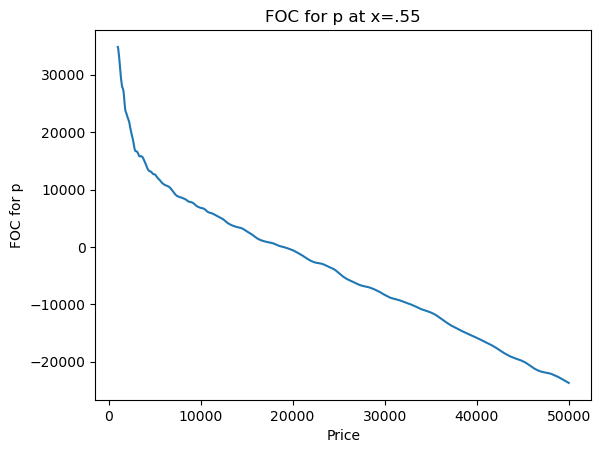

In [61]:
# Plot foc_p_x55
fig, ax = plt.subplots()
ax.plot(p_v, foc_p_x55)
plt.xlabel('Price')
plt.ylabel('FOC for p')
plt.title('FOC for p at x=.55')
plt.show()

In [ ]:
# Save objects in disk (computation time was 40 minutes)
object_names = ['p_vals', 'x_vals', 'P', 'X', 'profits', 'foc_p', 'foc_x']

def save_selected_objects(object_names, file_name):
    objects_to_save = {}
    for name in object_names:
        if name in globals():
            objects_to_save[name] = globals()[name]
        else:
            print(f"Warning: '{name}' not found in global namespace.")

    with open(file_name, 'wb') as file:
        pickle.dump(objects_to_save, file)
    print(f"Saved objects to {file_name}")

# Example usage: Ensure the objects exist in your current global namespace.
# object1, object2, ..., object10 = 1, 2, ..., 10  # Define your objects accordingly.
save_selected_objects(object_names, './resources/grids_t_100_000.pkl')

In [10]:
# Open the file in binary read mode
fpath = './resources/grids_t_100_000.pkl'
with open(fpath, 'rb') as file:
    data = pickle.load(file)
    for key in data.keys():
        print(key)
p_vals, x_vals, P, X, profits, foc_p, foc_x = [data[key] for key in data.keys()]

p_vals
x_vals
P
X
profits
foc_p
foc_x


Solve for equlibrium when $t=100,000$:

In [66]:
H = HHW_mkt(t=10_000)
H_sol = H.max_welf(p_guess=30_000, x_guess=.5, int='gh')
print(f'Equilibrium price, quality and total market demand: {H_sol}')

Equilibrium price, quality and total market demand: {'p': 17.671085749676987, 'x': 0.8696363629365866, 'Q': 0.999999999999329, 'W': 32175.006381235555}


In [ ]:
# Solve equilibrium for t from 1000 to 10_000 (save results in data frame)
t_vals = np.linspace(1_000, 135_000, 250)
results = []
for t in t_vals:
    print(f'Solving for t = {t}')
    H = HHW_mkt(t=t)
    H_sol = H.solve_eq(p_guess=20_000, x_guess=.5, N=1_000_000, int='mc')
    H_sol['t'] = t
    results.append(H_sol)
    print(f'Finished solving for t = {t}')

df = pd.DataFrame(results)

# Save dataframe in disk as pickle
df.to_pickle('./resources/df_t_1_000_100_000.pkl')

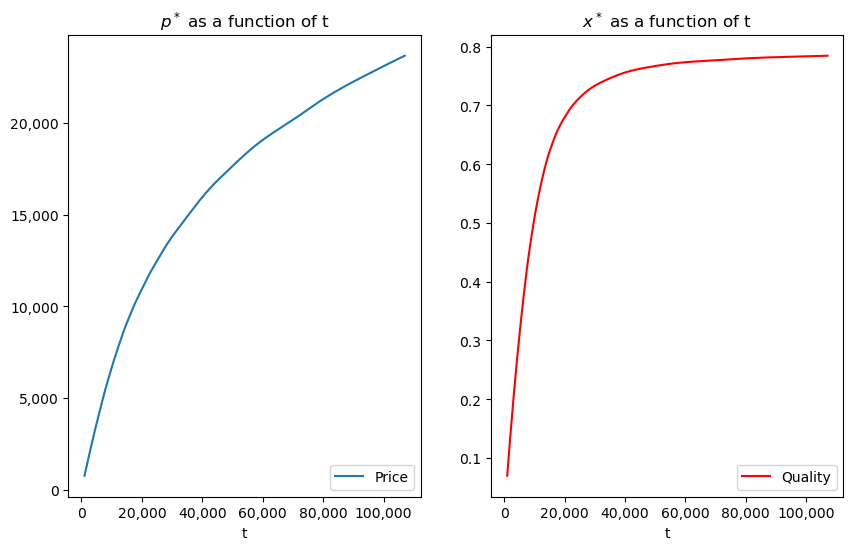

In [62]:
# Figure VIII in the Appendix
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 6))
line_p = ax.plot(df['t'], df['p'], label='Price')

ax.set_xlabel('t')
ax.set_title('$p^*$ as a function of t')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend(loc='lower right')

line_x = ax2.plot(df['t'], df['x'], color='red', label='Quality')
ax2.set_xlabel('t')
ax2.set_title('$x^*$ as a function of t')
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.legend(loc='lower right')
plt.show()

## Graphical analysis of margins:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Define the range for x values
H = HHW_mkt()

def plot_margins(x1=.55, p1=4800, x0=.50, p0=4000, t=1_000, max_μ=50_000):
    # Generate x values
    b = np.linspace(0, 1, 10000)

    # Create functions of margins
    @np.vectorize
    def ME(b):
        '''Exit margin'''
        if x1!=0:
            return (t*b + p1)/H.h(x1) if b>.5 else p1/H.h(x1)
        else:
            return np.inf
        
    @np.vectorize
    def MS(b):
        '''Switching margin'''
        if x1!=x0:
            return (p1-p0+t*b)/(H.h(x1)-H.h(x0)) if b>.5 else (p1-p0-t*(1-b))/(H.h(x1)-H.h(x0)) 
        else:
            return np.nan
        
    # Create vectors of margins
    μ_E = ME(b)
    μ_S = MS(b)
    μ_B = np.maximum(μ_E, μ_S)

    # Create the plot
    plt.figure(figsize=(10, 4))
    # Plot LSE
    y_start = p1/H.h(x1)
    plt.plot([.5, .5], [y_start, max_μ], color='black', linestyle='--', linewidth=1, label='Switching margin at LSE')
    plt.plot([0, .5], [y_start, y_start], color='black', linestyle='--', linewidth=1, label='Exit margin at LSE')
    plt.plot(b, μ_E, label=f'Exit margin')  
    if x1!=x0:
        plt.plot(b, μ_S, label=f'Switching margin')
    else:
        b_tilde =  (p1-p0-t)/(-2*t)   
        plt.axvline(x = b_tilde , color='red' , label=f'Switching margin')
    if x1>x0: 
        plt.fill_between(b, μ_B, max_μ, color='blue', alpha=0.3, label='Buyers')
    else:
        plt.fill_between(b, μ_E, μ_S, where=(μ_S > μ_E), color='blue', alpha=0.3, label='Buyers')
    plt.title(f'Margins Plot with x1 = {x1}, p1 = {p1}, x0 = {x0}, p0 = {p0}, t = {t}')
    plt.xlabel('b')
    plt.ylabel('μ')
    plt.ylim(0, max_μ)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

interactive_plot = interactive(plot_margins, x1=(0, 1, 0.01), p1=(0, 10_000, 100), x0=(0, 1, 0.01), p0=(0, 10_000, 100), t=(0, 10000, 50), max_μ=(0, 50000, 1000))
interactive_plot



interactive(children=(FloatSlider(value=0.55, description='x1', max=1.0, step=0.01), IntSlider(value=4800, des…

# Analytic Results

## Demand

Let $Q_i$ be the set of buyers of insurer $i$, which we assume is the one located at $b=0$. Note that:

$$ Q_i = \int_0^{\infty}\int_{\max\{0, \tilde\mu\}}^\infty\int_0^{\tilde b}f(\mu, \nu, b)db d\mu d\nu $$

where $\tilde b = \frac{1}{t}\Big[[\mu h_i + \nu \psi_i - p_i] - [\mu h_j + \nu \psi_j - p_j + t]\Big]$ and $\tilde\mu = \frac{p_i - \nu \psi_i}{h_i}$.

This can be written as

$$ Q_i = \int_0^{\bar\nu}\int_{\tilde\mu}^\infty\int_0^{\tilde b}f(\mu, \nu, b)db d\mu d\nu + \int_{\bar\nu}^\infty\int_0^\infty\int_0^{\tilde b}f(\mu, \nu, b)db d\mu d\nu $$

where $\bar\nu\equiv\frac{p_i}{\psi_i}$ is the value of $\nu$ such that $\tilde\mu = 0$.


Expressing demand in this way follows from focusing on LSE, otherwise the limits of integration are different (see interactive graphical analysis - e.g., $\tilde\mu$ becomes a function of $b$).

Also note that I am ommitting arguments $x_i$, $p_i$ and parameters $x_j$, $p_j$, $t$ to simplify the notation.

## Marginal Consumers (Switchers and Exiteers)
The partial derivative of $Q_i$ with respect to $p_i$ is given by:

$$ \frac{\partial Q_i}{\partial p_i} = \int_0^{\bar\nu}-\frac{\partial \tilde{\mu}}{\partial p_i}\int_0^{\tilde b}f(\tilde\mu, \nu, b)dbd\nu + \int_0^\infty \int_0^\infty\frac{\partial \tilde{b}}{\partial p_i}f(\mu, \nu, \tilde b)d\mu d\nu$$

$$ = -\frac{1}{2}\frac{\partial \tilde{\mu}}{\partial p_i}\int_0^{\bar\nu}f_{\mu\mid\nu}(\tilde\mu, \nu)f_\nu(\nu)d\nu + \frac{\partial \tilde{b}}{\partial p_i} Q$$

$$ = -\frac{1}{2}\frac{1}{h(x_i)}\int_0^{\bar\nu}f_{\mu\mid\nu}(\tilde\mu, \nu)f_\nu(\nu)d\nu - \frac{1}{t} Q$$

$$ \equiv - E - S$$

where $\frac{\partial \tilde{\mu}}{\partial p_i} = \frac{1}{h(x_1)}$ and $\frac{\partial \tilde{b}}{\partial p_i}=-\frac{1}{t}$

**Note:** In the paper,  $\frac{\partial \tilde{\mu}}{\partial p_i} = \frac{1}{x_1}$ and $\frac{\partial \tilde{b}}{\partial p_i}=-\frac{1}{2t}$. I think these are typos which follow from the asssumptions in earlier working papers: $h(x)=x$ (no moral hazard) and $d_0 = tb$, $d_1=(1-t)b$ (continuous travel cost).

## Profit maximization

The profit of insurer $i$ is given by:

$$\Pi_i = \int_0^{\bar\nu}\int_{\tilde\mu}^\infty\int_0^{\tilde b}(p-c)f(\mu, \nu, b)db d\mu d\nu + \int_{\bar\nu}^\infty\int_0^\infty\int_0^{\tilde b}(p-c)f(\mu, \nu, b)db d\mu d\nu $$

### FOC for $p$

The first order condition for $p\equiv p_i$ is given by:

$$ \frac{\partial \Pi_i}{\partial p} = Q_i -\frac{1}{2}\frac{\partial \tilde{\mu}}{\partial p}\int_0^{\bar\nu}(p-c)f_{\mu\mid\nu}(\tilde\mu, \nu)f_\nu(\nu)d\nu + \frac{\partial \tilde{b}}{\partial p_i} \int_0^{\infty}\int_{\max\{0, \tilde\mu\}}^\infty(p-c)f_{\mu\mid\nu}(\mu, \nu)f_\nu(\nu)d\mu d\nu = 0$$

$$ \Leftrightarrow Q_i - E \cdot \mathbf{E}[p-c\mid E] - S \cdot \mathbf{E}[p-c\mid S] = 0$$

$$ \Leftrightarrow \frac{Q_i}{M} -  p + \frac{E}{M}\mathbf{E}[c\mid E] + \frac{S}{M} \cdot \mathbf{E}[c\mid S] = 0$$

where $M \equiv E + S$ is the total number of marginal consumers.

### FOC for $x$:

The first order condition for $x\equiv x_i$ is given by:

$$ \int_0^\infty\int_{\max\{0, \tilde\mu\}}^\infty\int_0^{\tilde b} -\frac{\partial c}{\partial x}dbd\mu d\nu + \int_0^{\bar\nu}\int_0^{\tilde b} -\frac{\partial \tilde\mu}{\partial x}(p-c)f(\tilde\mu, \nu, b)dbd\nu + \int_0^\infty\int_{\max\{0, \tilde \mu\}}^\infty \frac{\partial \tilde{b}}{\partial x}(p-c)f(\mu, \nu, \tilde b)d\mu d\nu = 0$$

$$ \Leftrightarrow -Q_i \cdot \mathbf{E}[c'\mid B_i] + \int_0^{\bar\nu}\int_0^{\tilde b} -\frac{u'}{\frac{\partial u}{\partial \tilde \mu}}(p-c)f(\tilde\mu, \nu, b)dbd\nu + \int_0^\infty\int_{\max\{0, \tilde \mu\}}^\infty \frac{u'}{\frac{\partial u}{\partial \tilde b}}(p-c)f(\mu, \nu, \tilde b)d\mu d\nu = 0 $$

$$ \Leftrightarrow -Q_i \cdot \mathbf{E}[c'\mid B_i] + E \cdot \mathbf{E}[u'\cdot(p-c)\mid E] + S \cdot\mathbf{E}[u'\cdot(p-c)\mid S] = 0$$

$$ \Leftrightarrow -Q_i \cdot \mathbf{E}[c'\mid B_i] - E\cdot Cov[u', c \mid E] - S\cdot Cov[u', c\mid S] + E \cdot\mathbf{E}[u'\mid E]\mathbf{E}[(p-c)\mid E] + S \cdot\mathbf{E}[u'\mid S]\mathbf{E}[(p-c)\mid S] = 0$$

where $u\equiv \mu h(x) + \nu \psi(x) - td_i - \max \{0, \mu h(x_j) + \nu \psi(x_j) - td_j - p_j\}$ is willingness to pay, and $c'$, $u'$ denote partial derivatives wirth respect to $x$.

**Note:** In the authors' code, the FOC for $x$ seems to assume that $\mathbf{E}[p-c\mid E] = \mathbf{E}[p-c\mid S] = \mathbf{E}[p-c\mid M]$, so that we can use the first order condition for $p$ to simplify the FOC for $x$ by writing $\mathbf{E}[p-c\mid M]$ as $Q_i / M$. This may be a typo?

## References
André Veiga, E. Glen Weyl, Product Design in Selection Markets , The Quarterly Journal of Economics, Volume 131, Issue 2, May 2016, Pages 1007–1056, https://doi.org/10.1093/qje/qjw007
